In [1]:
# Code is provided as is

import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import scipy.io as io
from scipy.io import loadmat
from scipy.io import savemat
import torch.utils.data as data_utils
import torch.optim as optim
import matplotlib.pyplot as plt
import math

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [2]:
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from PIL import Image

try:
    from torchvision.transforms import InterpolationMode
    BICUBIC = InterpolationMode.BICUBIC
except ImportError:
    BICUBIC = Image.BICUBIC

def load_data(path,file):
    # See PPCA.ipynb how the features are generated
    name=path+file
    m=loadmat(name)
    x=torch.tensor(m['feature']).to(device)
    return x.float()

def load_datat(i):
    #name='c:/datasets/ILSVRC2016/Features_val_640/%d.mat'%(i+1)
    #name='c:/datasets/ILSVRC2016/features_val_640/'+names[i]
    name='d:/datasets/Imagenet/features_val_640/'+names[i]
    m=loadmat(name)
    x=torch.tensor(m['feature']).float().to(device)
    return x

def load_data_all(path,names,device):
    emptyx=1
    nc=len(names)
    for j in range(nc):
        x=load_data(path,names[j])
        x=x.to(device)
        if emptyx:
            allx=x
            emptyx=0
        else:
            allx=torch.cat((allx,x),dim=0)
        l=j
        if j==0:
            y=torch.zeros(x.shape[0]).to(device)+l
        else:
            y=torch.cat((y,torch.zeros(x.shape[0]).to(device)+l))
        if (j%200==199)|(j==nc-1):
            print(j+1)   
    return allx,y

class Net(nn.Module):
    def __init__(self,nclasses):
        super(Net, self).__init__()
        self.fc = nn.Linear(640, nclasses)

    def forward(self, x):
        x = self.fc(x)
        return x


In [4]:
#path='d:/datasets/Imagenet/'
path = 'd:/datasets/ILSVRC2016/'
name = path+'train.txt'
with open(name, 'r') as f:
    names = f.read().splitlines()
nc=len(names)
print(nc)

1000


In [5]:
from torch.utils.data import Dataset,TensorDataset, DataLoader
m=torch.load(path+'features_val_640.pth')
xt=m['xt']
yt=m['yt']
data=TensorDataset(xt,yt.long())
test_loader=DataLoader(data,batch_size=50000,shuffle=False)

In [8]:
# predict using the net

import pandas as pd
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix
def test_net(net,loader):
    with torch.no_grad():
        correct=0
        total=0
        for xi,yi in loader:
            pred=net(xi)
            py=torch.argmax(pred,dim=1)
            total+=xi.shape[0]
            #print(pred.shape,torch.max(py))
            correct+=torch.sum(py.squeeze()==yi.squeeze())
        acc=correct/total
        return acc.item()
res={'i':[],'acc':[]}
#pnames=torch.load('pnames100.pth')
for it in range(0,5):
#    names=pnames[it+1]
    nc=len(names)
#    xt,yt=load_data_all('d:/datasets/ILSVRC2016/features_val_640/',names)
    name='FC_640_10k_%d.pth'%(it+1)
    net=torch.load(name)
    acc=test_net(net,test_loader)
    res['i'].append(it+1)
    res['acc'].append(acc)
    print(it+1,acc)
df=pd.DataFrame(res)
print(df)
print('acc:%.4f(%.3f)'%(np.mean(res['acc']),np.std(res['acc'])))
name='res_net.csv'
df.to_csv(name)

1 0.3700428009033203
2 0.37000834941864014
3 0.3700370788574219
4 0.37011364102363586
5 0.37018445134162903
   i       acc
0  1  0.370043
1  2  0.370008
2  3  0.370037
3  4  0.370114
4  5  0.370184
acc:0.3701(0.000)


In [ ]:
# train linear head ImageNet 100 or 1k
import torch.nn as nn
import torch.nn.functional as F
from time import time
from torch.utils.data import Dataset,TensorDataset, DataLoader

minibatch=256
criterion = nn.CrossEntropyLoss()
torch.cuda.empty_cache()
pnames=torch.load('pnames100.pth')
for it in range(5):
    if 1: # for ImageNet-100
        names=pnames[it+1]
        x,y=load_data_all('d:/datasets/ILSVRC2016/features_640/',names,device)
        xt,yt=load_data_all('d:/datasets/ILSVRC2016/features_val_640/',names,device)
        print(x.shape,y.shape, xt.shape,yt.shape)
    n=y.shape[0]
    data=TensorDataset(x,y.long())
    loader=DataLoader(data,batch_size=minibatch,shuffle=True)
    nc=len(names)
    net=Net(nc)
    net=net.to(device)
    # Set optimizer with optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.03, weight_decay = 0.000)
    #optimizer = torch.optim.SGD(net.parameters(), lr=0.0001, weight_decay = 0.000)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,100,150,200,250], gamma=0.2)
    train_losses = []
    t0=time()
    # We use the pre-defined number of epochs to determine how many iterations to train the network on
    for ep in range(300):
        #Load in the data in batches using the train_loader object
        sumloss=0
        for xi, yi in loader:  
            xi,yi=xi.to(device),yi.to(device)
            # Forward pass
            output = net(xi)
            loss = criterion(output, yi.view(-1).long())
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            sumloss+=loss.item()*yi.shape[0]

        sumloss=sumloss/n
        train_losses.append(sumloss)
        scheduler.step()
        if ep%5==0:
            print(ep,sumloss,time()-t0)
        if ep%50==0:
            plt.plot(train_losses[:])  
            plt.show()
        name='FC_640_100_%d.pth'%(it+1)
        torch.save(net,name)

In [ ]:
# Save Imagenet10k train data in 10 large chuncks

#path='d:/datasets/ILSVRC2016/features_640/'
path='d:/datasets/ImageNet/features_640/'

nc1=nc//10
print(nc1)
for i in range(1,10):
    x,y=load_data_all(path,names[(i*nc1):((i+1)*nc1)],device)
    name='d:/datasets/ImageNet/features_640_%d.pth'%i
    torch.save(x,name)
    name='d:/datasets/ImageNet/labels_640_%d.pth'%i
    torch.save(y,name)
    print(x.shape,y.shape)
#xt,yt=load_data_all('d:/datasets/ILSVRC2016/features_val_640/',names)
#print(xt.shape,yt.shape)

In [4]:
# Load Imagenet10k train data
# (x,y) on CPU and (x1,y1) on GPU

from torch.utils.data import Dataset,TensorDataset, DataLoader
y=[]
for i in range(4):
    name='d:/datasets/ImageNet/labels_640_%d.pth'%i
    yi=torch.load(name)
    y.append(yi)
y=torch.cat(y).long()
y1=[]
for i in range(4,10):
    name='d:/datasets/ImageNet/labels_640_%d.pth'%i
    yi=torch.load(name)
    y1.append(yi)
y1=torch.cat(y1).long()
n=y.shape[0]
print(n)
x=torch.zeros(n,640,dtype=torch.float32)
ii=0
for i in range(4):
    name='d:/datasets/ImageNet/features_640_%d.pth'%i
    xi=torch.load(name)
    ni=xi.shape[0]
    x[ii:ii+ni,:]=xi.cpu()
    ii+=ni
    print(ii)
n=y1.shape[0]
print(n)
x1=torch.zeros(n,640,dtype=torch.float32,device=device)
ii=0
for i in range(4,10):
    name='d:/datasets/ImageNet/features_640_%d.pth'%i
    xi=torch.load(name)
    ni=xi.shape[0]
    x1[ii:ii+ni,:]=xi
    ii+=ni
    print(ii)
print(x.shape,y.shape,x1.shape,y1.shape)
del xi
data=TensorDataset(x,y.long())
loader=DataLoader(data,batch_size=256,shuffle=True)
data1=TensorDataset(x1,y1.long())
loader1=DataLoader(data1,batch_size=256,shuffle=True)
torch.cuda.empty_cache()

4588810
1136891
2303778
3443109
4588810
6471382
1118526
2246218
3373549
4436344
5474922
6471382
torch.Size([4588810, 640]) torch.Size([4588810]) torch.Size([6471382, 640]) torch.Size([6471382])


0 0 256 0.0 3.955878357976704e-05 2368.663330078125
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 4.669743450341323
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 4.596623098908769
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 4.5697889509854495
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 4.555147757287764
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 4.547341564013695
0 4.545110554399354 198.20037078857422


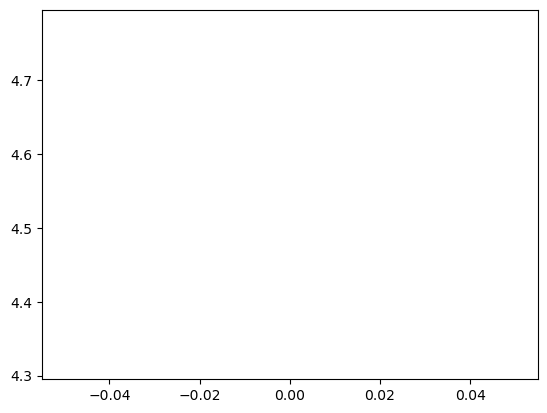

0 0 256 0.0 3.955878357976704e-05 1129.11376953125
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 4.494295964671818
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 4.500545512930487
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 4.506155008585814
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 4.508486518673277
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 4.510143352388211
1 4.510452629209365 396.5571551322937
0 0 256 0.0 3.955878357976704e-05 1168.8533935546875
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 4.492804784831
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 4.501082901213434
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 4.505145319478701
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 4.508369130796791
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 4.510406576934448
2 4.510573381908467 592.0906369686127
0 0 256 0.0 3.955

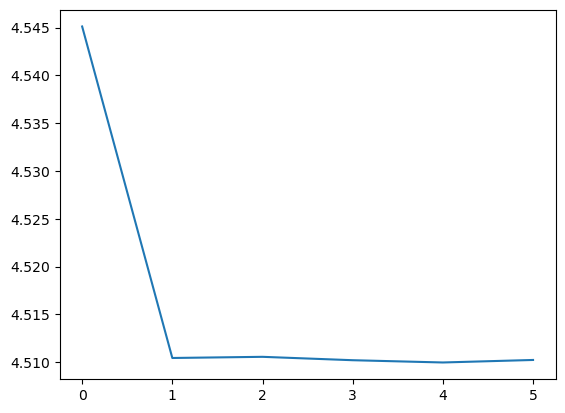

0 0 256 0.0 3.955878357976704e-05 1169.5997314453125
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 4.494345101465281
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 4.503946356733782
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 4.506526779970181
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 4.508460317927495
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 4.509524728899877
6 4.509980196934709 1367.8887672424316
0 0 256 0.0 3.955878357976704e-05 1093.7760009765625
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 4.49160564692417
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 4.5007891722779005
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 4.505468326652119
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 4.507907897535242
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 4.509412048153836
7 4.509722004307287 1562.1221969127655
0 0 256 0.

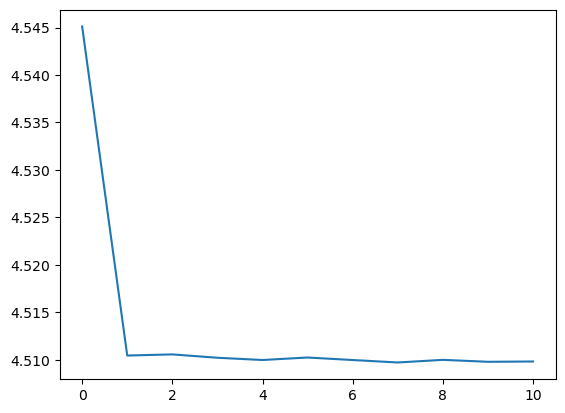

0 0 256 0.0 3.955878357976704e-05 1178.8726806640625
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 4.495265060620822
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 4.502947745005848
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 4.505972955695183
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 4.5075635624012245
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 4.509344581943145
11 4.5096272770354044 2333.2511179447174
0 0 256 0.0 3.955878357976704e-05 1185.198486328125
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 4.494336544000807
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 4.501126366474414
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 4.504666688020437
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 4.507495163270826
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 4.508678018527147
12 4.508994151129577 2526.762328863144
0 0 256 

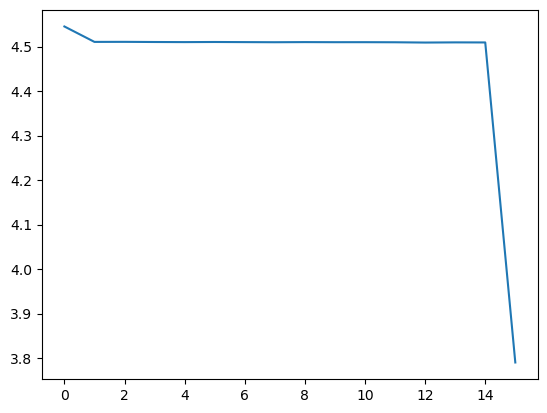

0 0 256 0.0 3.955878357976704e-05 1026.2171630859375
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.7441123031814105
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.7505772793820777
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.7543147933612904
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.7569288782214914
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.7583535907634187
16 3.759122591807457 3297.845005273819
0 0 256 0.0 3.955878357976704e-05 937.9693603515625
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.7399020443691287
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.74813023751429
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.7525097249237764
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.7552748157723057
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.7571627747574157
17 3.7575730148916193 3490.4525339603424
0

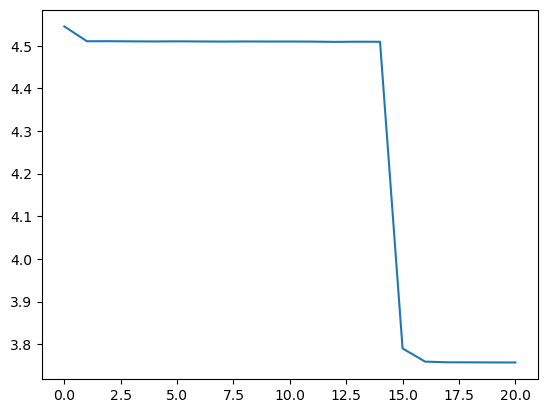

0 0 256 0.0 3.955878357976704e-05 1010.6958618164062
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.739832309919221
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.7476400134364667
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.7514893061776875
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.753903248355159
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.7564138150388957
21 3.7570448819485907 4267.668842315674
0 0 256 0.0 3.955878357976704e-05 1021.602294921875
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.7381063699384103
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.747319353147145
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.7518066975116637
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.753971231877322
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.7565552597856438
22 3.7571954979066113 4465.754494190216
0 0

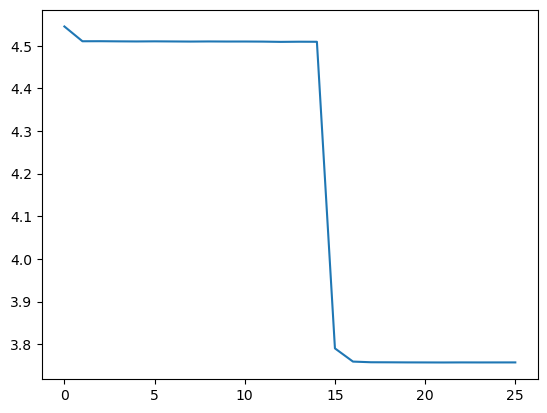

0 0 256 0.0 3.955878357976704e-05 1005.7020874023438
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.740561621267748
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.7473490221117975
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.7515653162137057
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.7544630118301363
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.7564727263447693
26 3.757098259549253 5238.419901371002
0 0 256 0.0 3.955878357976704e-05 1000.3026733398438
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.73953249995409
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.7468309186834428
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.7513843643994984
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.7545510550546313
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.756851596431395
27 3.757218370328769 5431.589867591858
0 0 

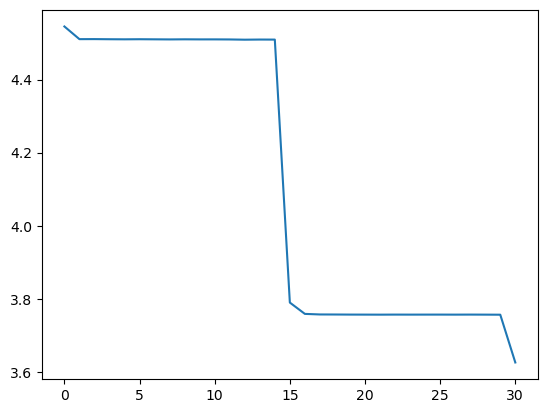

0 0 256 0.0 3.955878357976704e-05 967.796630859375
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.606772152472885
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.610754882579923
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.6133872805760583
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.6146665061138865
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.615927142081557
31 3.6165554275725236 6202.247362613678
0 0 256 0.0 3.955878357976704e-05 932.933837890625
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.604286973844833
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.6079114481505576
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.610599899619135
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.6135377361312337
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.615087102934199
32 3.615534687345122 6394.829262495041
0 0 256 0

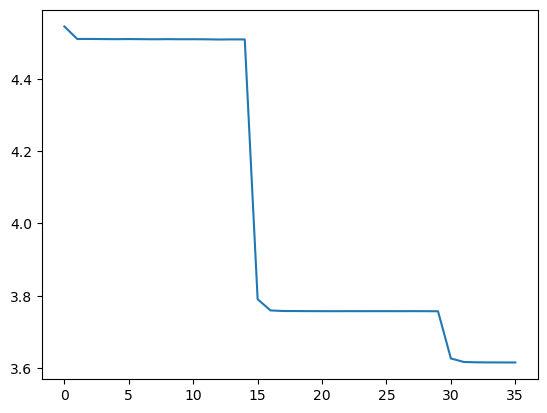

0 0 256 0.0 3.955878357976704e-05 971.2778930664062
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.604773008805484
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.608133421098322
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.610034318429209
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.6122074123292696
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.614440610641271
36 3.615097626410525 7164.997961759567
0 0 256 0.0 3.955878357976704e-05 948.0144653320312
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.603094640728754
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.60799317222297
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.6113796525215682
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.613460832953883
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.6146801053528854
37 3.615090859328948 7357.2657561302185
0 0 256 0

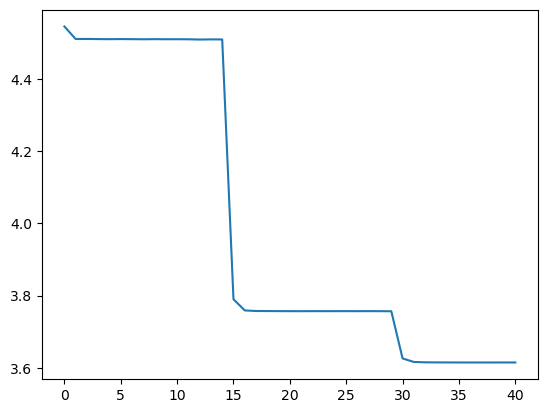

0 0 256 0.0 3.955878357976704e-05 955.8028564453125
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.6042938259020434
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.6080876878364583
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.6102252125448993
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.612733986206102
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.6146170021183197
41 3.615096386787102 8129.733131885529
0 0 256 0.0 3.955878357976704e-05 944.220947265625
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.6041004053479124
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.60819091384709
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.610071935262098
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.613146347315686
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.6147149242729584
42 3.6151237180156426 8322.375072479248
0 0 256

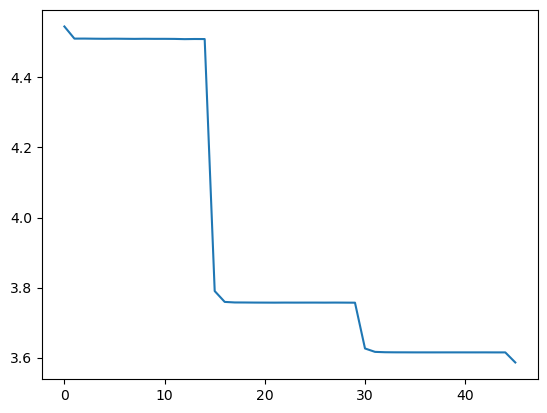

0 0 256 0.0 3.955878357976704e-05 952.9672241210938
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.581492445553177
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.581801982369368
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.581942925040395
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.582901710769075
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.583704234198271
46 3.584193018483514 9092.856395244598
0 0 256 0.0 3.955878357976704e-05 955.5926513671875
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.581660681726676
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.5822705988746657
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.582748543831188
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.58319595329402
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.5838162203952972
47 3.5838448722562233 9285.359378099442
0 0 256 0.

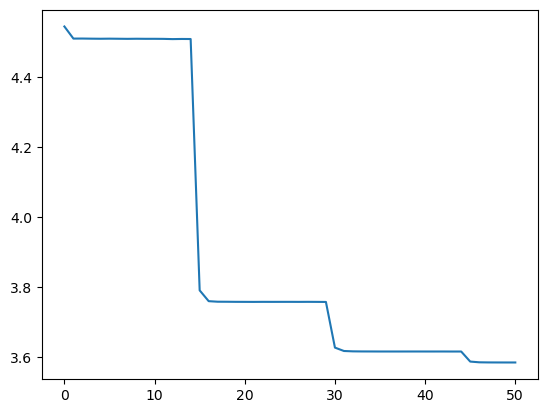

0 0 256 0.0 3.955878357976704e-05 1008.9576416015625
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.5805237576573714
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.581857814399027
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.5828832337463012
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.583063867420566
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.5838571239118866
51 3.583684619494308 10055.776450395584
0 0 256 0.0 3.955878357976704e-05 939.5730590820312
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.5801811643633785
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.5804173099613608
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.581255279339487
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.582658433390589
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.583484601737191
52 3.5836820242265466 10247.793619155884
0 0

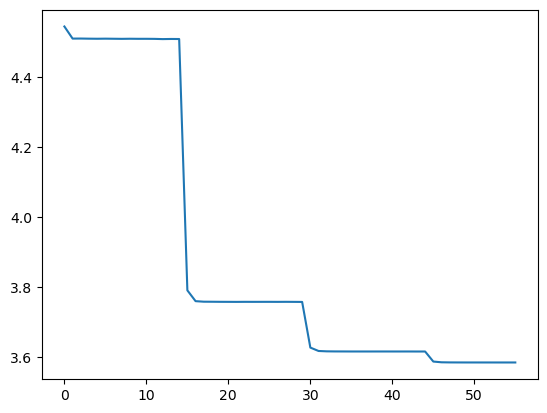

0 0 256 0.0 3.955878357976704e-05 1016.3538208007812
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.583627634699489
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.5819891778929427
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.5820892247165257
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.5824738093819404
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.5833768000957638
56 3.5836613979188594 11018.029527425766
0 0 256 0.0 3.955878357976704e-05 909.9658203125
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.57998431129864
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.581159367297365
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.582902034965486
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.5832405104278586
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.5836148000422425
57 3.5836660771455575 11210.782292604446
0 0 2

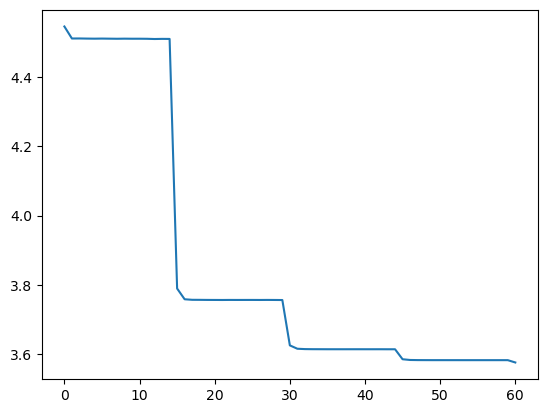

0 0 256 0.0 3.955878357976704e-05 986.178955078125
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.5773281968848356
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.5754677504231984
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.576018166616741
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.575928694233181
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.5768757391719097
61 3.5765711280528927 11981.766476154327
0 0 256 0.0 3.955878357976704e-05 923.2699584960938
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.5721421387798546
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.575466015466523
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.5754938594809036
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.5762090506955304
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.57648649600056
62 3.57651074679041 12174.34094786644
0 0 256

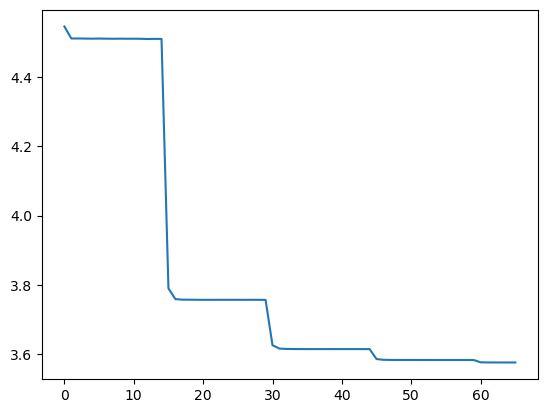

0 0 256 0.0 3.955878357976704e-05 945.8222045898438
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.5772492213651166
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.5773326833692387
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.5760443234353243
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.576459849374606
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.5765022506689257
66 3.5764866633319286 12946.96739411354
0 0 256 0.0 3.955878357976704e-05 961.171630859375
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.576205838902102
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.576061462324992
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.5763213164662475
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.5766728881060437
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.5767734694370237
67 3.576489332498725 13139.190022230148
0 0 

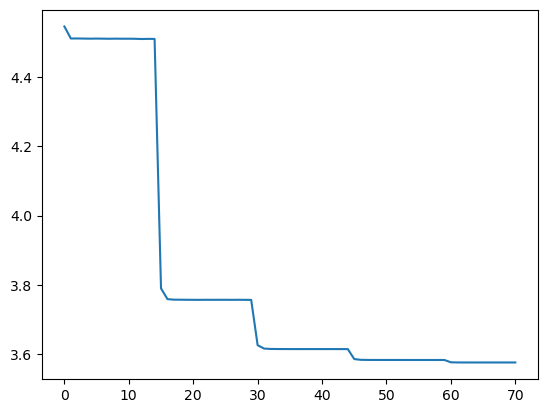

0 0 256 0.0 3.955878357976704e-05 967.3340454101562
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.573975428789454
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.5741346142795454
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.5754696421971457
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.576374875170544
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.5766496428917183
71 3.5764830607018068 13922.78789639473
0 0 256 0.0 3.955878357976704e-05 934.1966552734375
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.577749910716577
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.5770782738052245
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.5762194117627657
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.5763215953822955
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.5765414603528067
72 3.5764868372304726 14119.583267688751
0 

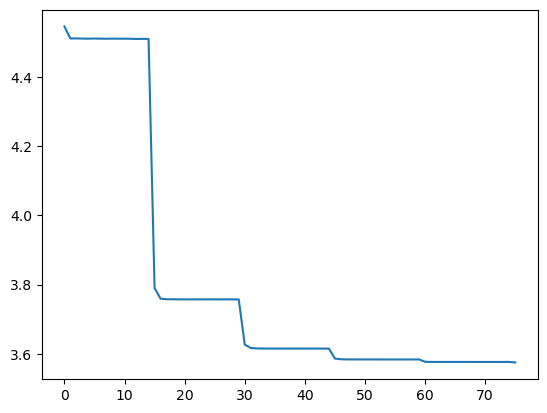

0 0 256 0.0 3.955878357976704e-05 952.2990112304688
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.5757776372271537
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.5760098553099415
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.575930906950911
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.5755197418010574
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.574950791668929
76 3.5748764158415214 14903.128341913223
0 0 256 0.0 3.955878357976704e-05 937.7413940429688
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.576819692384784
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.57376135957977
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.574343435565205
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.5745697193164356
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.5750320692996658
77 3.5748677789828838 15097.886334180832
0 0 

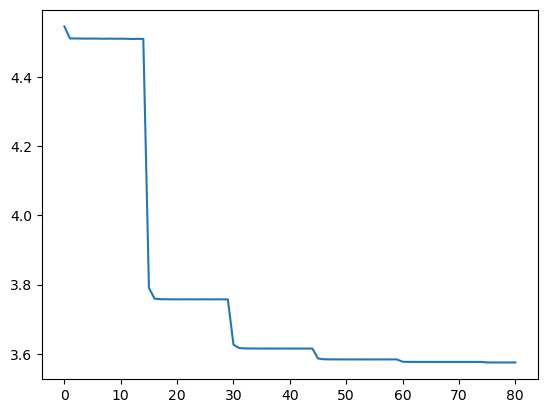

0 0 256 0.0 3.955878357976704e-05 943.7134399414062
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.5720330025497464
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.5744855511282196
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.5752977925074196
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.5751197346690167
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.57492924103355
81 3.574860730088627 15879.732976913452
0 0 256 0.0 3.955878357976704e-05 1009.02490234375
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.5743752961288435
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.5745401341577536
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.574632034015941
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.5745121754124205
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.5745103977812627
82 3.5748604135454727 16074.9928252697
0 0 2

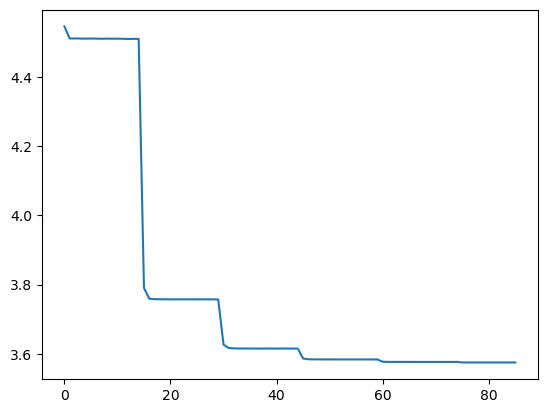

0 0 256 0.0 3.955878357976704e-05 937.8919067382812
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.5734584914283776
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.572902751603146
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.573524497592197
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.5737222494716545
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.574557187732786
86 3.5748604575848018 16859.86247229576
0 0 256 0.0 3.955878357976704e-05 985.8065185546875
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.5766996574507
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.5752716837338916
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.5748346682976564
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.5747267231470152
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.5748523729599637
87 3.574861058154269 17055.673841953278
0 0 25

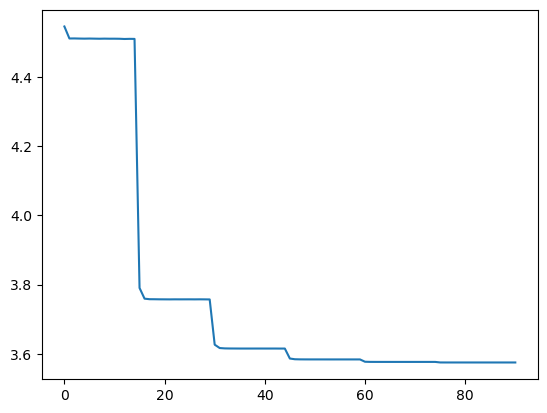

0 0 256 0.0 3.955878357976704e-05 957.1826782226562
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.5740040746187343
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.5736175184078602
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.5740542731155434
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.5740050680972706
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.5748579355032897
91 3.5748596494194316 17837.645028591156
0 0 256 0.0 3.955878357976704e-05 947.9508666992188
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.5751164670971574
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.5753601552888634
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.575747273077137
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.5751514566221725
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.5746991480179378
92 3.5748589307451843 18032.917361736298

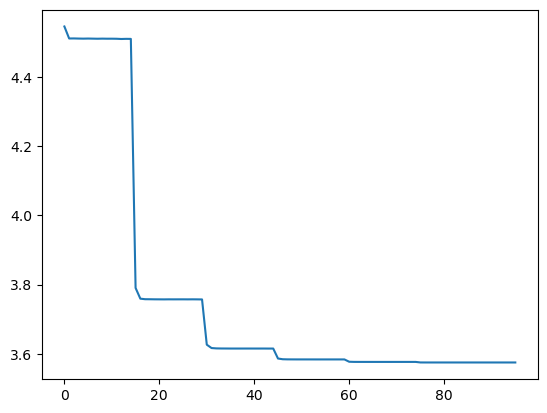

0 0 256 0.0 3.955878357976704e-05 993.8237915039062
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.5734658381144913
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.5740900762842327
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.5743329484872914
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.574584282219493
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.574637990350313
96 3.5748600792182397 18816.063666582108
0 0 256 0.0 3.955878357976704e-05 957.3128051757812
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.5738307923184722
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.5740085665351695
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.574500431909014
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.575095950600713
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.574855999002214
97 3.574858843150469 19010.121419668198
0 0 

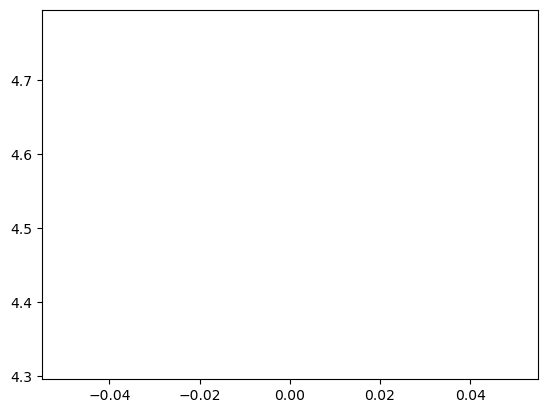

0 0 256 0.0 3.955878357976704e-05 1159.687255859375
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 4.492134269233707
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 4.501425798589583
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 4.506144559029019
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 4.508348658257839
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 4.510253428793
1 4.5104964348095065 386.574471950531
0 0 256 0.0 3.955878357976704e-05 1293.9869384765625
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 4.494599738016066
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 4.502255682096525
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 4.506087063096658
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 4.508360795095688
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 4.509533857040389
2 4.509979404527369 579.6464104652405
0 0 256 0.0 3.95

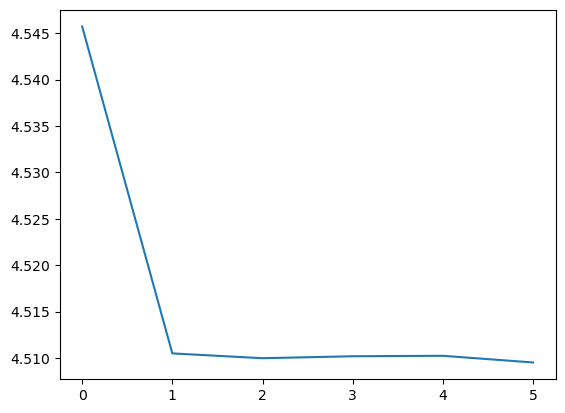

0 0 256 0.0 3.955878357976704e-05 1139.4180908203125
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 4.4972545752817705
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 4.503225276755646
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 4.506696159196795
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 4.508681476703008
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 4.509722151045277
6 4.509723294687634 1350.4091579914093
0 0 256 0.0 3.955878357976704e-05 1256.0841064453125
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 4.496108132325541
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 4.5043959159698685
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 4.507954960164089
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 4.50936825307094
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 4.51003830545862
7 4.510242120376487 1544.3972551822662
0 0 256 0.

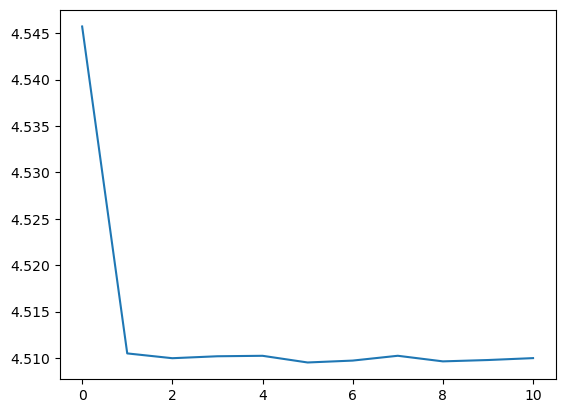

0 0 256 0.0 3.955878357976704e-05 1129.0377197265625
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 4.494070955221101
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 4.503222126054893
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 4.506035095841894
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 4.508439238792148
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 4.509514250070563
11 4.509369244368638 2315.3294837474823
0 0 256 0.0 3.955878357976704e-05 1115.7166748046875
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 4.4951476866752
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 4.501967599537415
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 4.5067163728471495
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 4.508648926006972
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 4.509232330606803
12 4.509539728036545 2508.21288561821
0 0 256 0.0

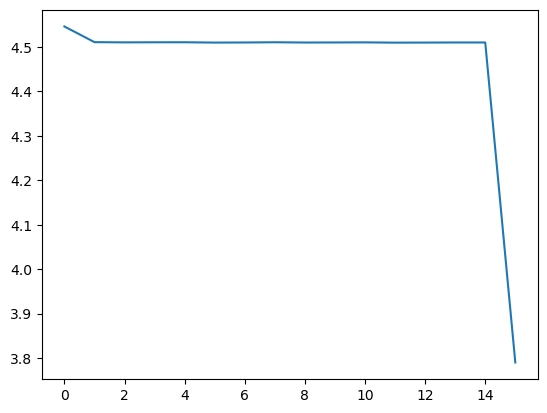

0 0 256 0.0 3.955878357976704e-05 988.8685302734375
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.745136699935207
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.75033730936756
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.7544706876849356
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.7569156606025533
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.7587792000124547
16 3.7590705581268344 3280.7663280963898
0 0 256 0.0 3.955878357976704e-05 1006.112548828125
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.740100836193201
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.746376562079287
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.7517167747604088
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.754451538414255
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.75689768190377
17 3.7574627554171673 3473.704663515091
0 0 256

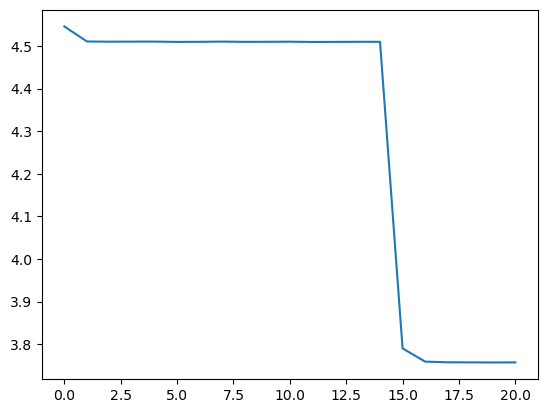

0 0 256 0.0 3.955878357976704e-05 977.50341796875
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.7400534213472825
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.748225793556401
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.7520565398564503
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.754541123126434
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.7567458567468877
21 3.7570085377744893 4243.421883821487
0 0 256 0.0 3.955878357976704e-05 987.16357421875
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.7416452795828503
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.7473463323634517
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.7510369711022604
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.753995446596582
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.7566076689347025
22 3.7570429402744003 4436.335837841034
0 0 256

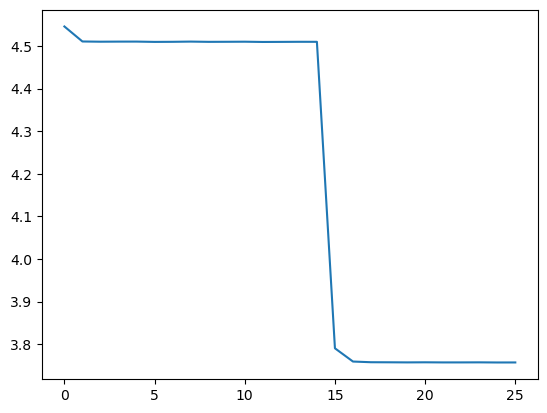

0 0 256 0.0 3.955878357976704e-05 1029.688232421875
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.739578081153414
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.7469290659921493
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.7512501749249014
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.75445714279245
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.756369113371661
26 3.757116006605978 5205.983157157898
0 0 256 0.0 3.955878357976704e-05 998.5789184570312
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.740728499290474
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.748351424873028
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.751905768133957
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.7550625281785095
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.7568063099174824
27 3.757042998268476 5398.452292919159
0 0 256 0

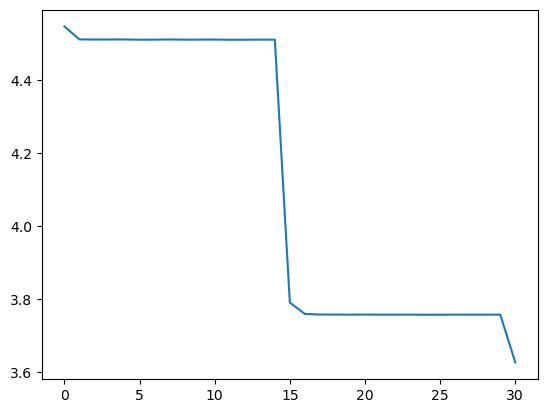

0 0 256 0.0 3.955878357976704e-05 940.180419921875
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.6067948785207484
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.6102714387076014
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.612576801295496
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.6149006929730403
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.616059118708893
31 3.616454581885735 6169.594942569733
0 0 256 0.0 3.955878357976704e-05 1025.756591796875
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.602740116676865
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.607728292196686
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.6114586225436325
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.6136278412962066
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.615185520904067
32 3.6155856556466315 6362.202298879623
0 0 256

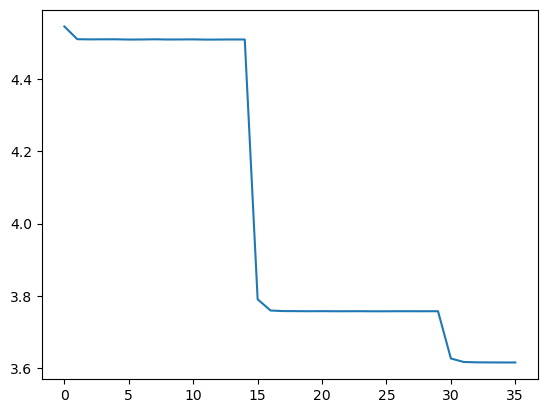

0 0 256 0.0 3.955878357976704e-05 1042.7940673828125
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.6004230413934257
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.605359832402833
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.6095986718568738
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.612566663494019
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.6148349822970847
36 3.615131630241095 7133.127555608749
0 0 256 0.0 3.955878357976704e-05 926.6438598632812
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.606604433190613
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.608571023481672
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.6113955121328027
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.612557573473876
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.614834482387017
37 3.6150833452647935 7324.9213745594025
0 0 2

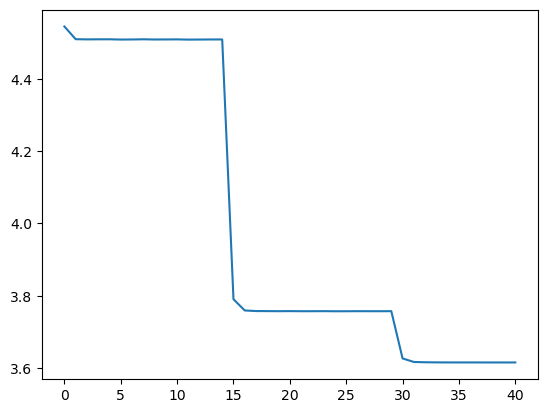

0 0 256 0.0 3.955878357976704e-05 948.9840087890625
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.6064304373038922
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.609453506390955
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.6108599428601136
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.612484651580836
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.614467122254197
41 3.6150218506419254 8094.735917568207
0 0 256 0.0 3.955878357976704e-05 939.8063354492188
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.603717924913332
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.6070019966047897
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.609760296401255
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.6127303813623297
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.614338355139973
42 3.6151539582865166 8287.062429189682
0 0 25

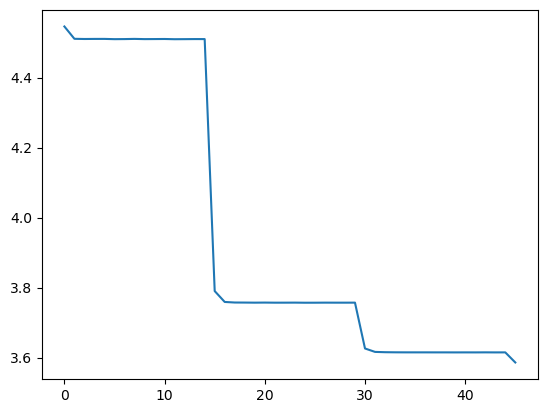

0 0 256 0.0 3.955878357976704e-05 983.5761108398438
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.582068889778355
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.583632487755497
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.5838682014435865
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.5835445634663543
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.58413443329657
46 3.5842060618000957 9058.141896247864
0 0 256 0.0 3.955878357976704e-05 937.0574340820312
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.5803287722734627
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.5815989162785313
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.5819122951323683
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.582429518896898
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.5835796121992565
47 3.583863128916485 9250.906666755676
0 0 25

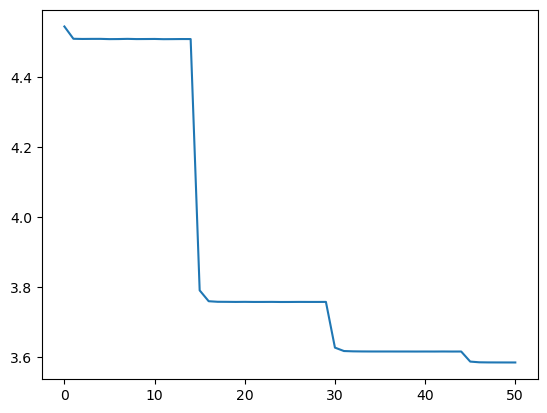

0 0 256 0.0 3.955878357976704e-05 968.3922119140625
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.5789936332335563
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.5800546166209157
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.5809364452057806
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.581980011134144
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.583029828951593
51 3.583687720463802 10021.80123758316
0 0 256 0.0 3.955878357976704e-05 934.30615234375
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.5806877492669797
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.5811423236960795
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.5814612585737184
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.582416558218651
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.5833654686340104
52 3.5836698631507446 10214.3270175457
0 0 256

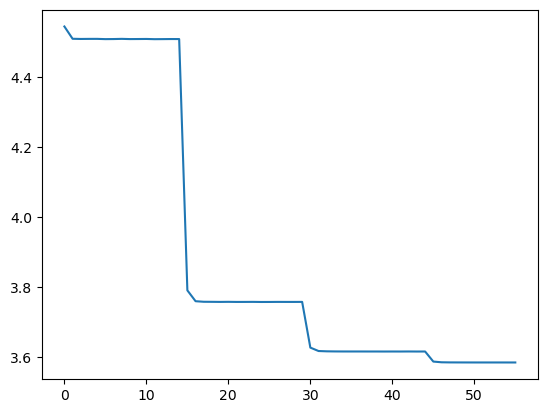

0 0 256 0.0 3.955878357976704e-05 953.9088134765625
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.5837701145264638
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.582131445323801
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.5824995323054756
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.582626591006264
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.5835721910759997
56 3.583648886638156 10984.6591360569
0 0 256 0.0 3.955878357976704e-05 981.6924438476562
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.5778833943295023
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.5802573650786775
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.5812851143004965
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.5827437862182094
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.5838130047905907
57 3.5836766746084487 11177.308143854141
0 0

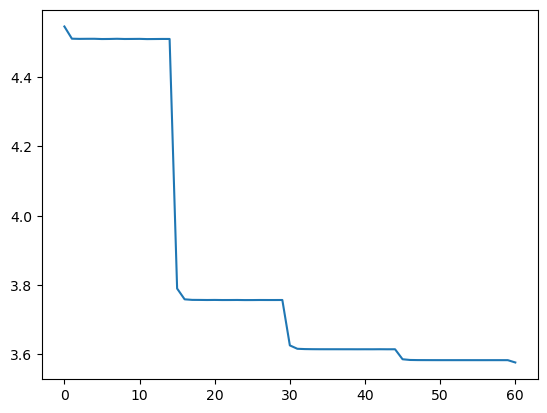

0 0 256 0.0 3.955878357976704e-05 1025.2711181640625
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.574945185306611
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.5761988861196854
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.5754409244058123
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.575825270464113
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.5764833182924827
61 3.576580307262433 11949.079646110535
0 0 256 0.0 3.955878357976704e-05 951.12353515625
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.574838547254957
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.5759211284236345
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.576746479626354
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.5762426468941606
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.5763995097593693
62 3.57652218748202 12141.859787940979
0 0 25

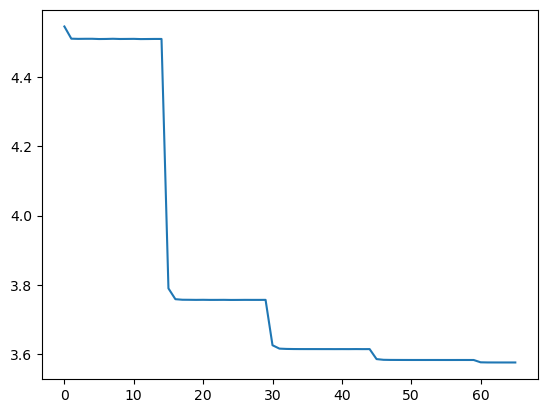

0 0 256 0.0 3.955878357976704e-05 976.1852416992188
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.57345195333848
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.5744089296889916
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.576501098181864
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.576587132075402
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.576763334031758
66 3.57648739377251 12912.532583713531
0 0 256 0.0 3.955878357976704e-05 1034.21923828125
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.573992999872526
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.5754521451263437
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.5755509202894937
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.57569169278344
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.5765598534681997
67 3.57648369188981 13104.64189863205
0 0 256 0.0 

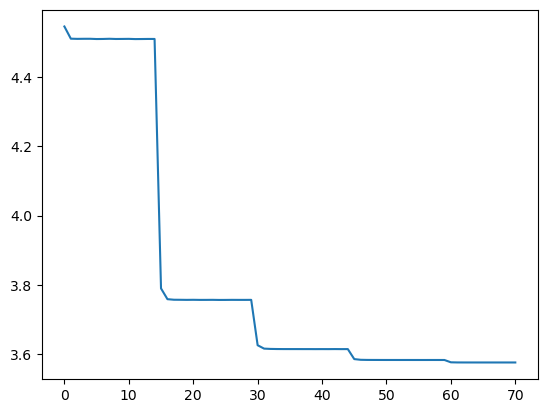

0 0 256 0.0 3.955878357976704e-05 955.453369140625
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.5766370127016063
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.5763299620659637
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.5761472589016288
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.576135833252896
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.576459891416318
71 3.5764887615598613 13875.548170566559
0 0 256 0.0 3.955878357976704e-05 959.5248413085938
2048000 849920 1198336 0.18521577489588803 0.18517466593688953 3.578255303825888
4096000 1699584 2396672 0.3703757619077713 0.37034933187377905 3.5768214559161255
6144000 2549248 3595008 0.5555357489196545 0.5555239978106685 3.577108085460078
8192000 3398912 4793344 0.7406957359315378 0.7406986637475581 3.5766188907152126
10240000 4248576 5991680 0.9258557229434211 0.9258733296844476 3.5768249128419196
72 3.5764803239070946 14068.20354628563
0 0 

In [ ]:
# train linear head on Imagenet-10k
# data part on CPU, part on GPU

import torch.nn as nn
import torch.nn.functional as F
from time import time
from torch.utils.data import Dataset,TensorDataset, DataLoader


minibatch=256
criterion = nn.CrossEntropyLoss()
torch.cuda.empty_cache()
n=y.shape[0]
n1=y1.shape[0]
pnames=torch.load('pnames100.pth')
for it in range(5): # number of runs
    data=TensorDataset(x,y.long())
    loader=DataLoader(data,batch_size=minibatch,shuffle=True)
    data1=TensorDataset(x1,y1.long())
    loader1=DataLoader(data1,batch_size=minibatch,shuffle=True)
    nc=len(names)
    net=Net(nc)
    net=net.to(device)
    # Set optimizer with optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.03, weight_decay = 0.000)
    #optimizer = torch.optim.SGD(net.parameters(), lr=0.0001, weight_decay = 0.000)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15,30,45,60,75], gamma=0.2)
    train_losses = []
    t0=time()
    # We use the pre-defined number of epochs to determine how many iterations to train the network on
    for ep in range(100):
        #Load in the data in batches using the train_loader object
        sumloss=0
        j=0
        j1=0
        ite = iter(loader)
        ite1 = iter(loader1)
        for i in range(0,n+n1,minibatch):
        #for xi, yi in loader1:  
            if j/n<j1/n1:
                xi,yi=next(ite,(None,None))
                if xi is None:
                    break
                j+=xi.shape[0]
            else:
                xi,yi=next(ite1,(None,None))
                if xi is None:
                    break
                j1+=xi.shape[0]
            xi,yi=xi.to(device),yi.to(device)
            # Forward pass
            output = net(xi)
            loss = criterion(output, yi.view(-1).long())
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            sumloss+=loss.item()*yi.shape[0]
            if i%2048000==0:
                print(i,j,j1,j/n,j1/n1,sumloss/(i+1))

        sumloss=sumloss/(n+n1)
        train_losses.append(sumloss)
        scheduler.step()
        if ep%1==0:
            print(ep,sumloss,time()-t0)
        if ep%5==0:
            plt.plot(train_losses[:])  
            plt.show()
            #minibatch*=2
            #loader=DataLoader(data,batch_size=minibatch,shuffle=True)
        name='FC_640_10k_%d.pth'%(it+1)
        torch.save(net,name)